<a href="https://colab.research.google.com/github/silvia-j-escobar/ExternDataScience/blob/main/Compare_3_OCR_Engines_on_a_Mortgage_PDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Task: Compare 3 OCR Engines on a Mortgage PDF
# Silvia J Escobar
# Tesseract OCR
# 📌 Step 1: Install Dependencies
!apt install tesseract-ocr
!pip install pymupdf pytesseract opencv-python pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [10]:
# =======================
# 📌 Step 2: Import Libraries
# =======================
import fitz  # PyMuPDF
import cv2
import pytesseract
import numpy as np
from PIL import Image

In [11]:
# =======================
# 📌 Step 3: Load Scanned PDF
# =======================
# Upload "sample_mortgage_document.pdf" manually in Colab
from google.colab import files

uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]  # Get uploaded file name

# Open the scanned mortgage document
doc = fitz.open(pdf_path)

Saving LenderFeesWorksheetNew (1).pdf to LenderFeesWorksheetNew (1) (3).pdf


In [12]:
# =======================
# 📌 Step 4: Try Extracting Text Without OCR (Will Fail)
# =======================
page = doc[0]
text = page.get_text("text")  # Normal text extraction
print("Extracted Text:", text)  # Expecting empty or incorrect output

Extracted Text: Your actual rate, payment, and cost could be higher. Get an official Loan Estimate before choosing a loan.
Fee Details and Summary
Applicants:
Application No:
Date Prepared:
Loan Program:
Prepared By:
THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Fees Worksheet" is provided for informational purposes ONLY, to assist
you in determining an estimate of cash that may be required to close and an estimate of your proposed monthly mortgage 
payment. Actual charges may be more or less, and your transaction may not involve a fee for every item listed.
Total Loan Amount:  
Interest Rate:
Term/Due In:
Fee
Paid To
Paid By (Fee Split**)
Amount
PFC / F / POC
TOTAL ESTIMATED FUNDS NEEDED TO CLOSE:
TOTAL ESTIMATED MONTHLY PAYMENT:
Total Estimated Funds
Total Monthly Payment
Purchase Price (+)
Alterations (+)
Land (+)
Refi (incl. debts to be paid off) (+)
Est. Prepaid Items/Reserves (+)
Est. Closing Costs (+)
Loan Amount (-)
Principal & Interest
Other Financing (P & I)
Hazard Insurance

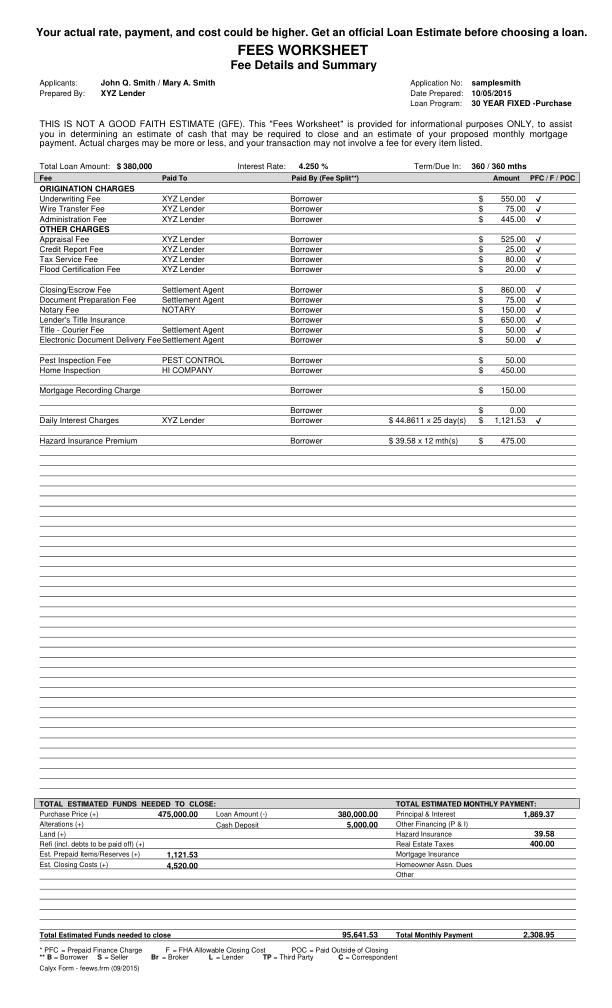

In [13]:
# =======================
# 📌 Step 5: Convert PDF to Image for OCR
# =======================
pix = page.get_pixmap()
img = np.array(Image.frombytes("RGB", [pix.width, pix.height], pix.samples))
display(Image.fromarray(img))

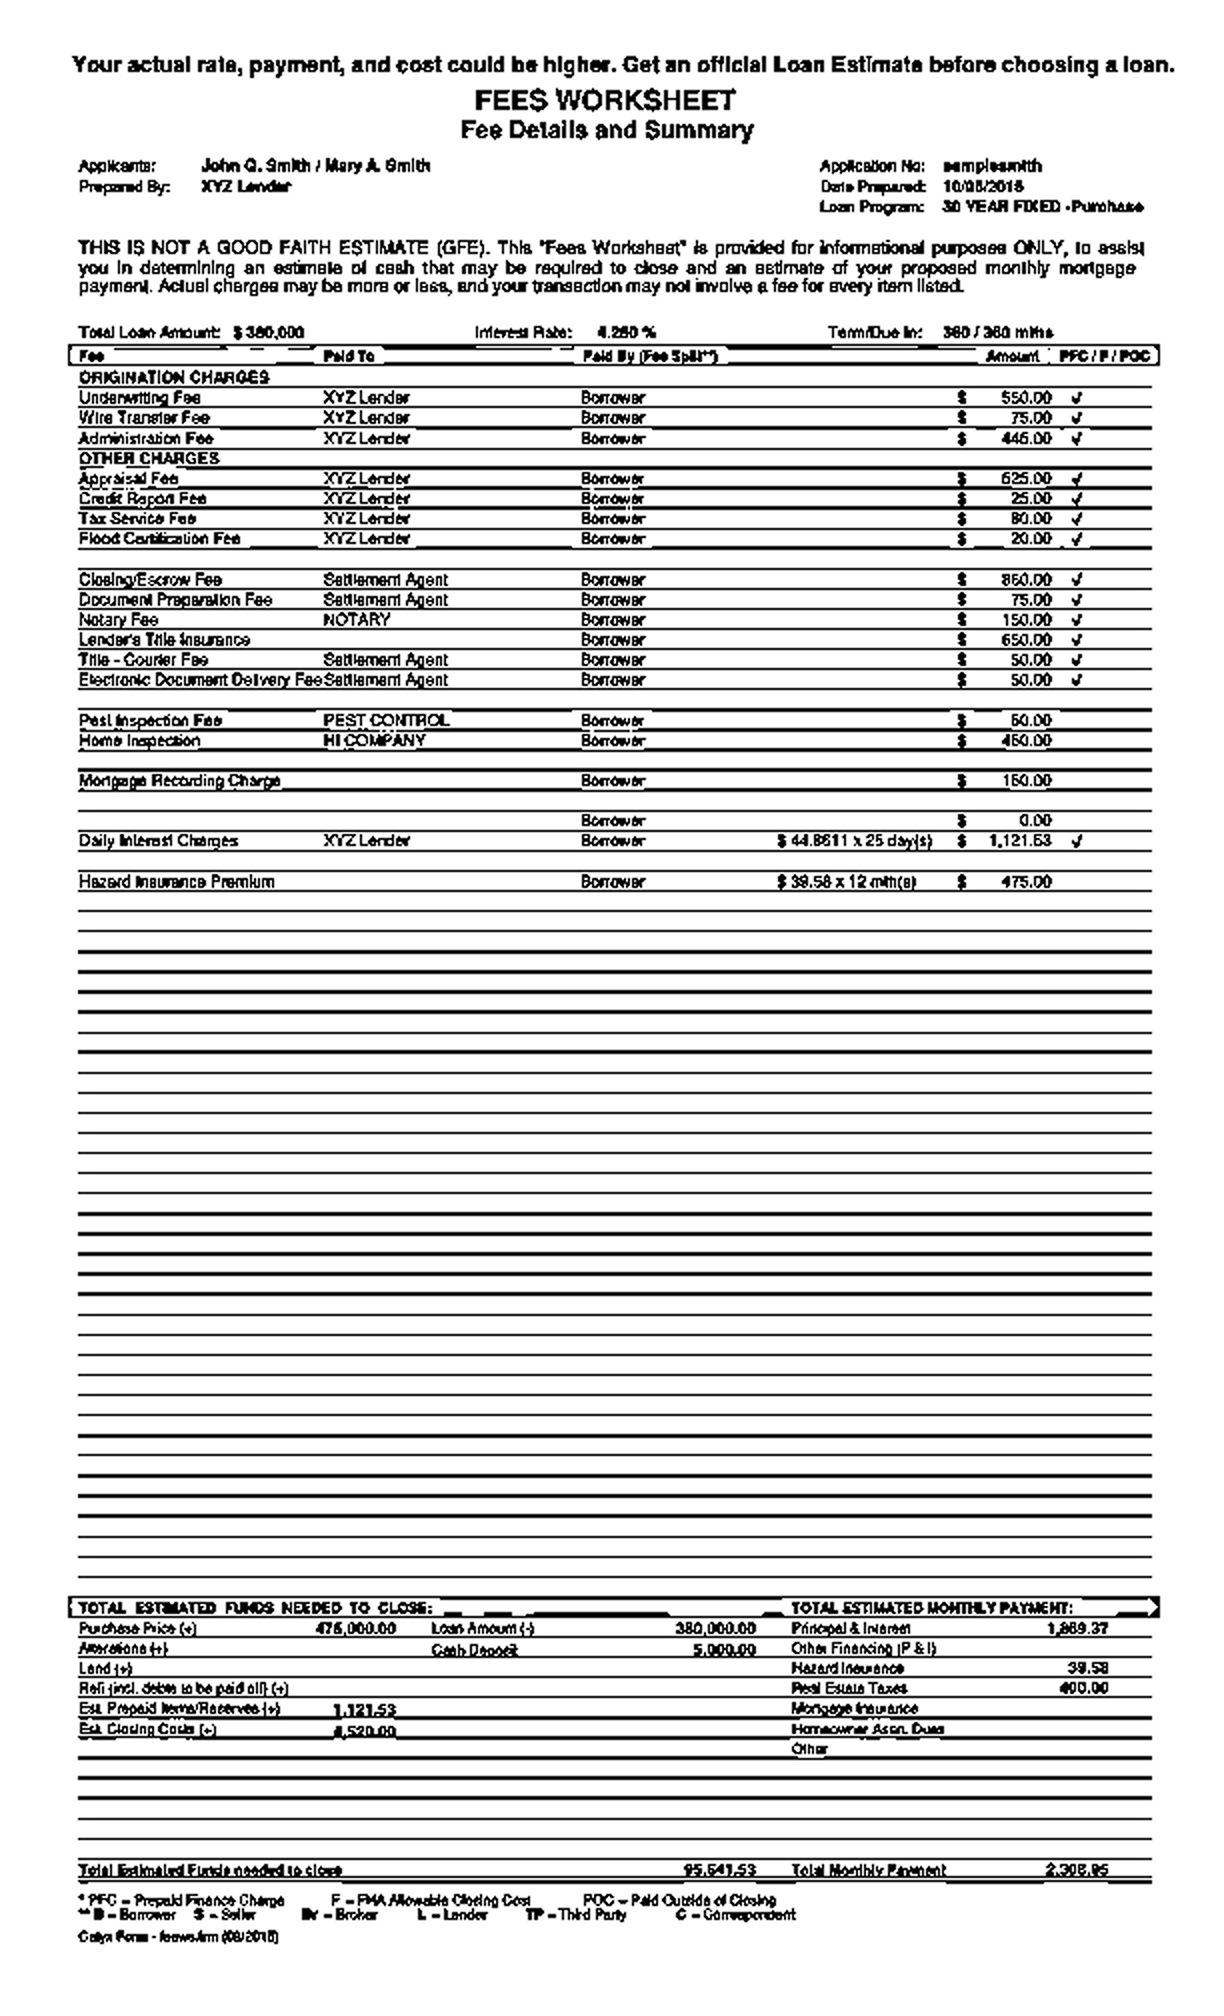

In [14]:
# =======================
# 📌 Step 6: Preprocess Image for Better OCR Accuracy
# =======================

# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply Adaptive Thresholding for contrast enhancement
gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

# Apply Bilateral Filtering to reduce noise while preserving edges
gray = cv2.bilateralFilter(gray, 9, 75, 75)

# Resize image for better OCR accuracy (Tesseract performs better on larger text)
scale_percent = 200  # Increase image size by 200%
width = int(gray.shape[1] * scale_percent / 100)
height = int(gray.shape[0] * scale_percent / 100)
gray = cv2.resize(gray, (width, height), interpolation=cv2.INTER_CUBIC)

# Show the preprocessed image
display(Image.fromarray(gray))

In [15]:
# =======================
# 📌 Step 7.1: Perform OCR on the Image
# =======================
# Use optimized Tesseract OCR configurations
custom_config = r'--oem 3 -l eng'
ocr_text = pytesseract.image_to_string(gray, config=custom_config)


print("OCR Extracted Text:\n", ocr_text)

# =======================
# 📌 Step 7.2: Extract Bounding Boxes from OCR Output
# =======================

ocr_data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

# Print first 5 extracted words with bounding boxes
for i in range(5):
    print(f"Word: {ocr_data['text'][i]}, BBox: ({ocr_data['left'][i]}, {ocr_data['top'][i]}, {ocr_data['width'][i]}, {ocr_data['height'][i]})")

OCR Extracted Text:
 Your actual raia, payment, and cost cauld be higher. Get an official Loan Estimate befare choosing a loan.

FEES WORKSHEET
Fee Details and Summary

Apnikenta: John &. Smith Mary & Smith Appication Na: pamplesmith
Prepared By: XYZ Lover Date Prepared 10/08/2018
Loan Program: 30 YEAR FIXED -Purohate

THIS IS NOT A GOOD FAITH ESTIMATE (GFE). This "Faas Worksheat® ts provided for informational purposea ONLY, In assis}
you In determining an estamele of cash that may be required to close and an setimate of your proposed monthly morgage
payment. Aciuel charges may ba more of lesa, and your tansaction may nol mmolve @ fee for avery item lleted

 

 

 

 

 

 

Total Loan Arount: $380,000 Inferest Piste: 4.280% TenmDue ie: 340/380 mite

Feo ~~ Pais To — Paid 5 Seoul PFC IPOS
ORIGINATION CHARGED

Undarastting Foe XYZ Lerdor Borrawor = $50.00 v

Velre Transios Fee XYZ Lender Borrower, £ 75.00 Vv

Admmisiration Foe
OTHER CHARGES

    

Borrower $446.00 ¥

 

 

 

 

 

 

 

In [16]:
# =======================
# 📌 Step 8: Post-OCR Processing & Extracting Key Information
# =======================

import re
import json

# 📌 Step 8.1: Preprocess OCR Text (Cleaning & Formatting)
ocr_text = " ".join(ocr_text.split())  # Remove extra spaces & newlines
ocr_text = re.sub(r'[^a-zA-Z0-9\s,.%-]', '', ocr_text)  # Remove special chars

# 📌 Step 8.2: Fix Common OCR Errors
ocr_text = re.sub(r'\bL0AN\b', 'LOAN', ocr_text, flags=re.IGNORECASE)
ocr_text = re.sub(r'\bM0RTGAGE\b', 'MORTGAGE', ocr_text, flags=re.IGNORECASE)
ocr_text = re.sub(r'\b1NTEREST\b', 'INTEREST', ocr_text, flags=re.IGNORECASE)


print("Final Cleaned OCR Text:\n", ocr_text)

Final Cleaned OCR Text:
 Your actual raia, payment, and cost cauld be higher. Get an official Loan Estimate befare choosing a loan. FEES WORKSHEET Fee Details and Summary Apnikenta John . Smith Mary  Smith Appication Na pamplesmith Prepared By XYZ Lover Date Prepared 10082018 Loan Program 30 YEAR FIXED -Purohate THIS IS NOT A GOOD FAITH ESTIMATE GFE. This Faas Worksheat ts provided for informational purposea ONLY, In assis you In determining an estamele of cash that may be required to close and an setimate of your proposed monthly morgage payment. Aciuel charges may ba more of lesa, and your tansaction may nol mmolve  fee for avery item lleted Total Loan Arount 380,000 Inferest Piste 4.280% TenmDue ie 340380 mite Feo  Pais To  Paid 5 Seoul PFC IPOS ORIGINATION CHARGED Undarastting Foe XYZ Lerdor Borrawor  50.00 v Velre Transios Fee XYZ Lender Borrower,  75.00 Vv Admmisiration Foe OTHER CHARGES Borrower 446.00  Bostow or 8000  Bestow br 3 20.00  Closing Escrow Fea Sattiamem Agent Borraw

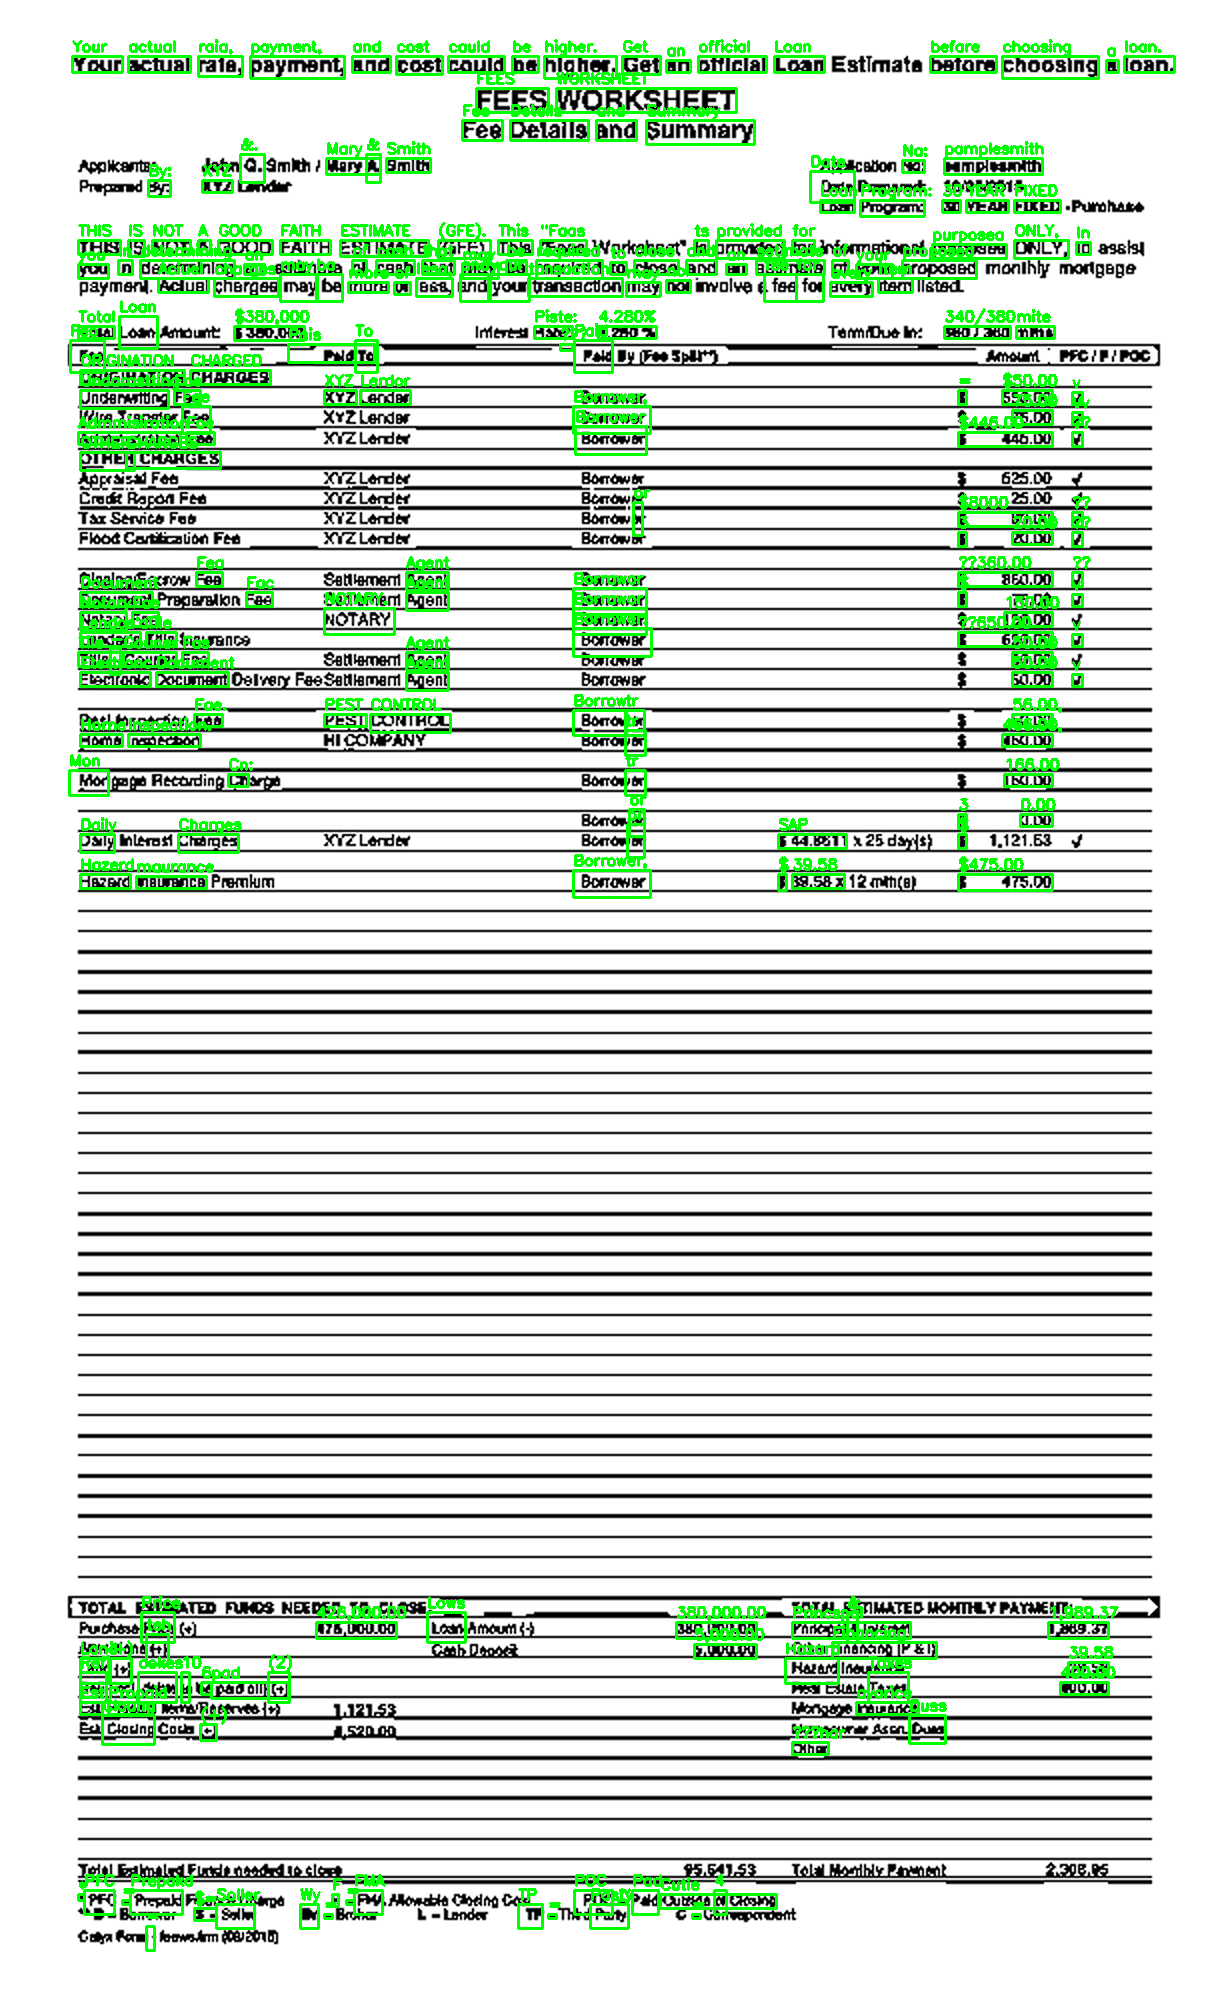

In [17]:
import cv2
from PIL import Image

# Convert image to OpenCV BGR format
img_bgr = cv2.cvtColor(gray, cv2.COLOR_RGB2BGR)

# Get OpenCV image height for correct y-coordinate transformation
page_height = gray.shape[0]

# Define confidence threshold (ignore low-confidence words)
confidence_threshold = 40

# 📌 Step 9.1: Loop through Extracted OCR Words & Draw Bounding Boxes
for i in range(len(ocr_data["text"])):
    word = ocr_data["text"][i].strip()
    x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]
    conf = int(ocr_data["conf"][i])  # Convert confidence to int

    # Ignore empty words & low-confidence OCR text
    if not word or conf < confidence_threshold:
        continue

    # Fix y-coordinate to match OpenCV's top-left origin
    #y = page_height - y

    # Draw bounding box
    cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(img_bgr, word, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# 📌 Step 9.2: Convert Back to RGB & Display the Image
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(img_rgb))

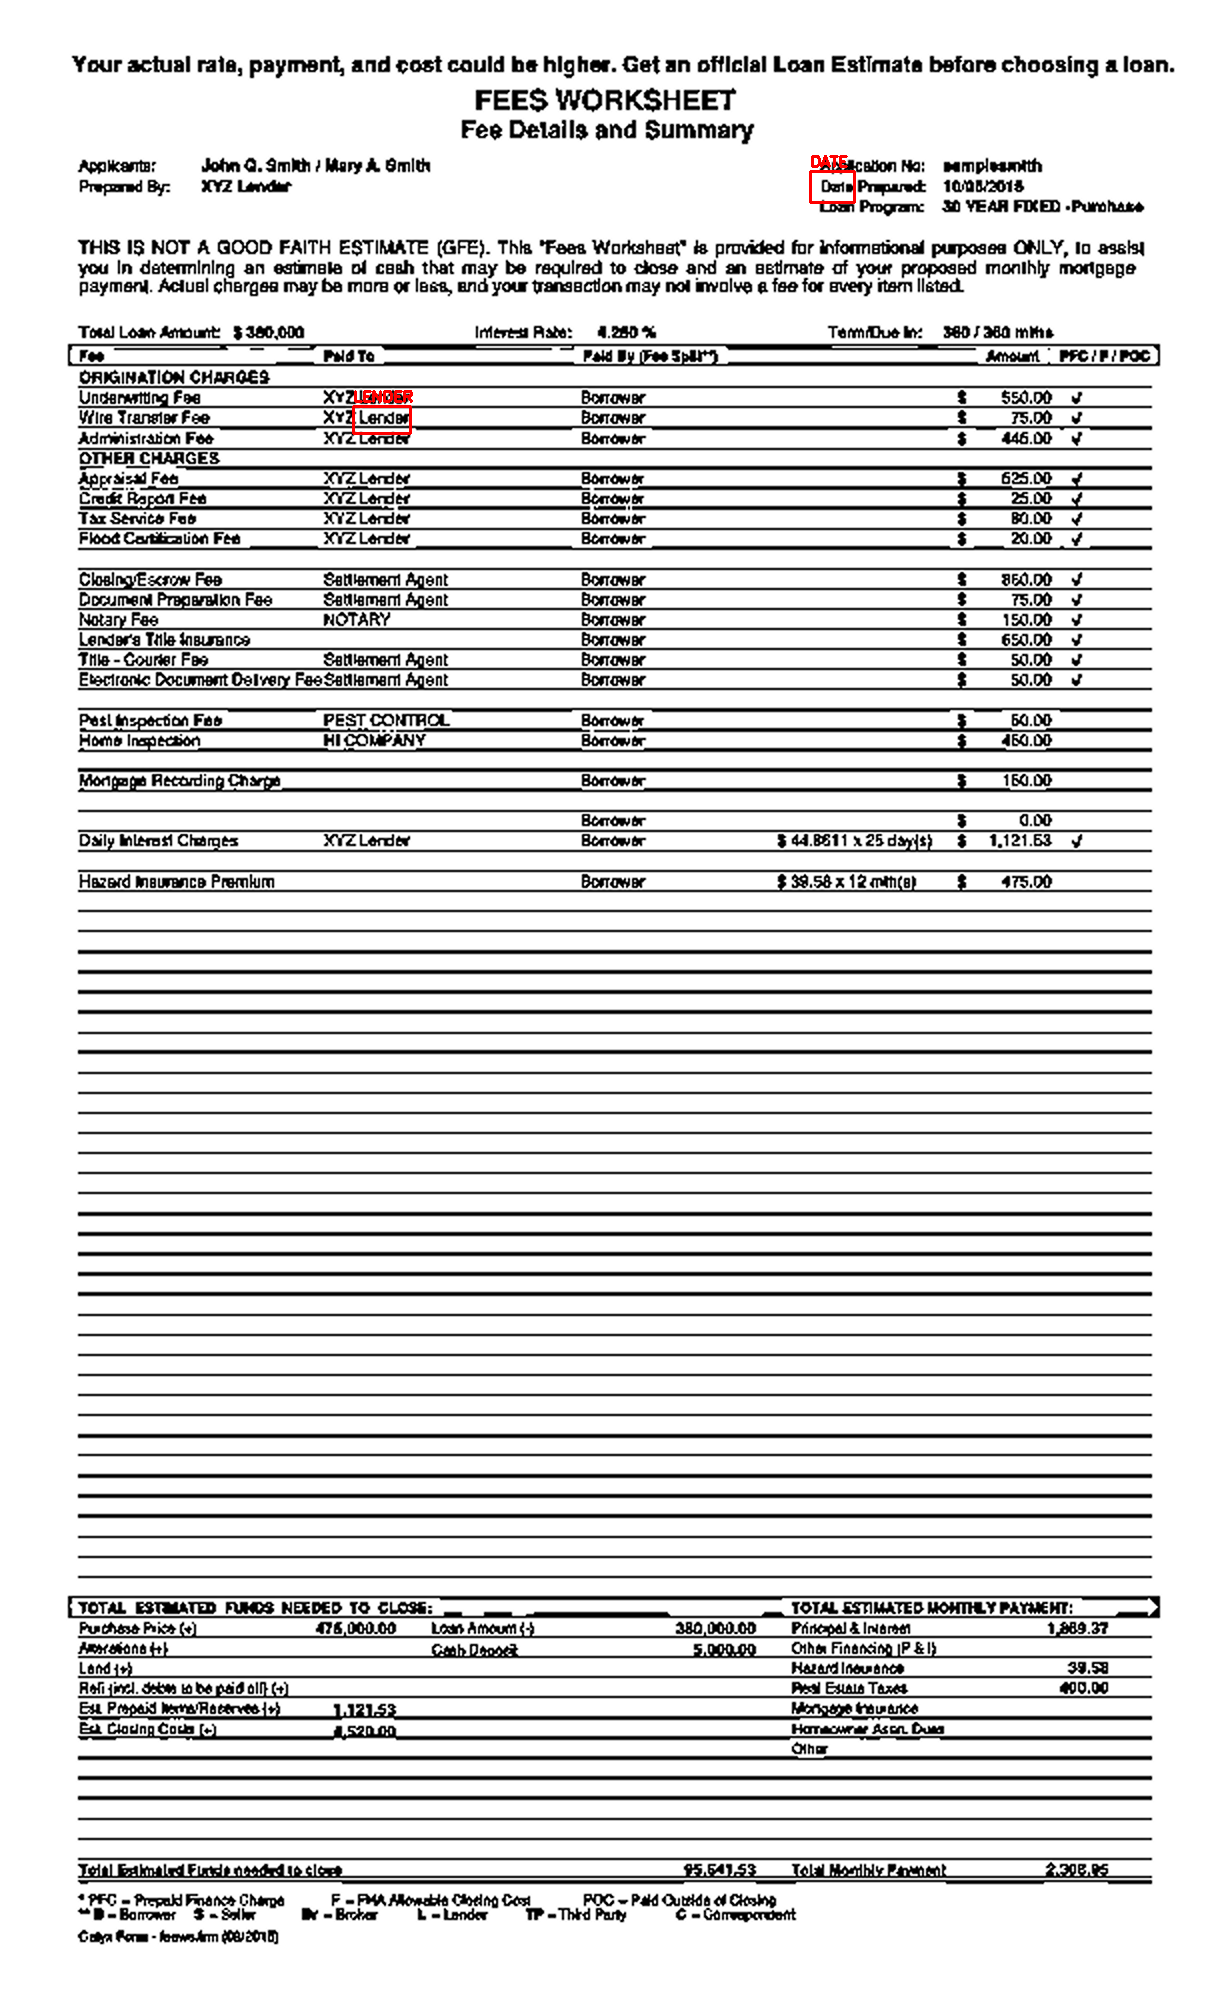

In [18]:
# =======================
# 📌 Step 10: Draw Bounding Boxes on Relevant Key Fields from Mortgage Document
# =======================

import cv2

# Convert image to OpenCV BGR format
img_bgr = cv2.cvtColor(gray, cv2.COLOR_RGB2BGR)

# Define key fields dynamically based on document content
key_fields = ["MORTGAGE", "NOTE", "LENDER", "PROPERTY ADDRESS", "DATE", "SIGNATURE"]

# Loop through extracted OCR words
for i in range(len(ocr_data["text"])):
    word = ocr_data["text"][i].strip().upper()  # Convert to uppercase for better matching
    x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]

    if word in key_fields:  # Highlight only key fields found in the document
        cv2.rectangle(img_bgr, (x, y), (x + w, y + h), (0, 0, 255), 2)  # Red bounding box
        cv2.putText(img_bgr, word, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Convert back to RGB for display
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
display(Image.fromarray(img_rgb))

In [19]:
import json

# Initialize an empty dictionary to store extracted key field data
extracted_data = {}

# Loop through detected words to extract key fields
for i in range(len(ocr_data["text"])):
    word = ocr_data["text"][i].strip().upper()
    x, y, w, h = ocr_data["left"][i], ocr_data["top"][i], ocr_data["width"][i], ocr_data["height"][i]

    if word in key_fields:
        extracted_data[word] = {
            "text": word,
            "bounding_box": [x, y, w, h]
        }

# Convert extracted data into JSON format
json_output = json.dumps(extracted_data, indent=4)

# Print structured JSON output
print(json_output)

{
    "DATE": {
        "text": "DATE",
        "bounding_box": [
            810,
            171,
            44,
            31
        ]
    },
    "LENDER": {
        "text": "LENDER",
        "bounding_box": [
            353,
            406,
            57,
            27
        ]
    }
}


In [8]:
!apt-get install -y tesseract-ocr

!pip install pytesseract
!pip install easyocr
!pip install "paddleocr>=2.0.1"
!pip install pymupdf
!pip install opencv-python


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 1s (171 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...


Saving LenderFeesWorksheetNew (1).pdf to LenderFeesWorksheetNew (1) (2).pdf


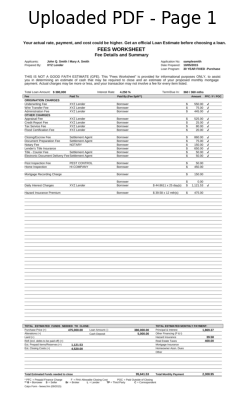

In [7]:
# 2: Upload and convert PDF
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Install poppler-utils and pdf2image
!apt-get install -y poppler-utils
!pip install pdf2image

# Now import after installation
from pdf2image import convert_from_path

# Upload your file
uploaded = files.upload()
pdf_path = f"/content/{list(uploaded.keys())[0]}"

# Convert first page to image
images = convert_from_path(pdf_path, dpi=300)
image = images[0]
image_path = '/content/page.png'
image.save(image_path)

# Show preview
plt.imshow(image)
plt.axis('off')
plt.title("Uploaded PDF - Page 1")
plt.show()

Paddle OCR


In [43]:
# Import required libraries
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import cv2
import numpy as np
from pdf2image import convert_from_path
import os
from google.colab import files
import io

RuntimeError: PDX has already been initialized. Reinitialization is not supported.

In [21]:
# Upload your PDF file
print("📁 Upload your PDF file:")
uploaded = files.upload()

📁 Upload your PDF file:


Saving LenderFeesWorksheetNew (1).pdf to LenderFeesWorksheetNew (1) (4).pdf


In [22]:
# Get the uploaded file name
pdf_filename = list(uploaded.keys())[0]
pdf_path = f"/content/{pdf_filename}"
print(f"✅ File uploaded: {pdf_filename}")

✅ File uploaded: LenderFeesWorksheetNew (1) (4).pdf


In [23]:
# Convert PDF to images
def convert_pdf_to_images(pdf_path, dpi=300):
    """
    Convert PDF pages to images

    Args:
        pdf_path (str): Path to PDF file
        dpi (int): Resolution for conversion (higher = better quality, larger file)

    Returns:
        list: List of PIL Image objects
    """
    try:
        images = convert_from_path(pdf_path, dpi=dpi)
        print(f"✅ Successfully converted {len(images)} page(s)")
        return images
    except Exception as e:
        print(f"❌ Error converting PDF: {e}")
        return []



In [24]:
# Convert the uploaded PDF
images = convert_pdf_to_images(pdf_path)

✅ Successfully converted 1 page(s)


In [25]:
# Display converted pages
def display_pdf_pages(images, max_pages=3):
    """Display the first few pages of the converted PDF"""
    pages_to_show = min(len(images), max_pages)

    fig, axes = plt.subplots(1, pages_to_show, figsize=(5*pages_to_show, 7))
    if pages_to_show == 1:
        axes = [axes]

    for i in range(pages_to_show):
        axes[i].imshow(images[i])
        axes[i].set_title(f'Page {i+1}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

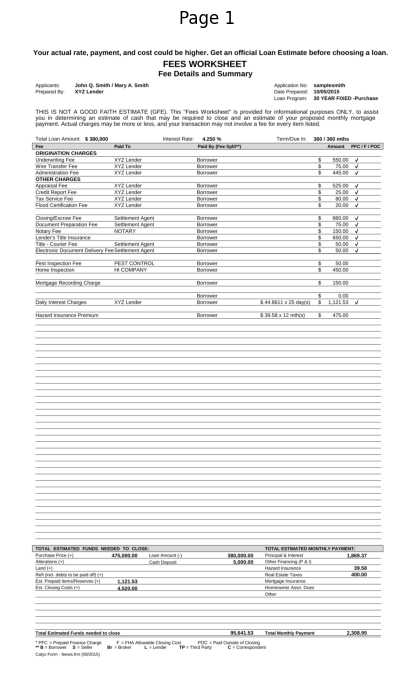

In [26]:
if images:
    display_pdf_pages(images)
else:
    print("❌ No images to display")

In [27]:
# OCR Processing
# Initialize PaddleOCR
def initialize_ocr(language='en', use_gpu=False):
    """
    Initialize PaddleOCR with specified settings

    Args:
        language (str): Language code ('en', 'ch', 'fr', etc.)
        use_gpu (bool): Whether to use GPU acceleration

    Returns:
        PaddleOCR: Initialized OCR object
    """
    try:
        ocr = PaddleOCR(
            use_textline_orientation=True,  # Enable text angle classification
            lang=language,       # Set language
        )
        print(f"✅ PaddleOCR initialized for language: {language}")
        return ocr
    except Exception as e:
        print(f"❌ Error initializing OCR: {e}")
        return None

In [28]:
# Initialize OCR
ocr = initialize_ocr('en')

❌ Error initializing OCR: name 'PaddleOCR' is not defined


In [29]:
# Process images with OCR
def process_image_ocr(ocr, image, page_num=1):
    """
    Process a single image with OCR

    Args:
        ocr: PaddleOCR object
        image: PIL Image object
        page_num (int): Page number for identification

    Returns:
        tuple: (results, processed_image_path)
    """
    # Save image temporarily
    img_path = f'/content/page_{page_num}.png'
    image.save(img_path, 'PNG')

    # Perform OCR
    try:
        result = ocr.ocr(img_path)
        print(f"✅ OCR completed for page {page_num}")
        return result, img_path
    except Exception as e:
        print(f"❌ OCR error for page {page_num}: {e}")
        return None, img_path

In [30]:
# Process all pages
all_results = []
all_image_paths = []

for i, image in enumerate(images):
    result, img_path = process_image_ocr(ocr, image, i+1)
    all_results.append(result)
    all_image_paths.append(img_path)

❌ OCR error for page 1: 'NoneType' object has no attribute 'ocr'


In [31]:
# Visualization functions
def parse_ocr_result(ocr_result):
    """
    Parse OCR result and extract boxes, texts, and scores safely
    Handle both old format and new dictionary format

    Args:
        ocr_result: OCR results from PaddleOCR

    Returns:
        tuple: (boxes, texts, scores) or (None, None, None) if no valid results
    """
    if not ocr_result:
        return None, None, None


    # Handle list containing dictionary (newer PaddleOCR format)
    if isinstance(ocr_result, list) and len(ocr_result) > 0:
        first_element = ocr_result[0]

        # If first element is a dictionary, extract from it
        if isinstance(first_element, dict):

            if 'rec_texts' in first_element and 'rec_scores' in first_element and 'rec_polys' in first_element:
                boxes = first_element['rec_polys']
                txts = first_element['rec_texts']
                scores = first_element['rec_scores']

                return boxes, txts, scores
            else:
                return None, None, None

        # Handle traditional list format [[box, [text, score]], ...]
        elif isinstance(first_element, list):

            boxes = []
            txts = []
            scores = []

            for i, line in enumerate(ocr_result[0]):
                try:
                    if len(line) >= 2:
                        box = line[0]  # Bounding box coordinates

                        # Check if line[1] is a tuple/list with text and score
                        if isinstance(line[1], (list, tuple)) and len(line[1]) >= 2:
                            txt = line[1][0]  # Text
                            score = line[1][1]  # Confidence score
                        elif isinstance(line[1], str):
                            txt = line[1]
                            score = 1.0  # Default score
                        else:
                            continue

                        boxes.append(box)
                        txts.append(txt)
                        scores.append(score)

                except Exception as e:
                    print(f"Error parsing line {i}: {e}")
                    continue

            return boxes, txts, scores

    # Handle direct dictionary format
    elif isinstance(ocr_result, dict):

        if 'rec_texts' in ocr_result and 'rec_scores' in ocr_result and 'rec_polys' in ocr_result:
            boxes = ocr_result['rec_polys']
            txts = ocr_result['rec_texts']
            scores = ocr_result['rec_scores']

            return boxes, txts, scores
        else:

            return None, None, None

    print("Debug - Unrecognized OCR result format")
    return None, None, None

def draw_ocr_results(image_path, ocr_result):
    """
    Draw bounding boxes and text on the image

    Args:
        image_path (str): Path to the image file
        ocr_result: OCR results from PaddleOCR

    Returns:
        tuple: (annotated_image, boxes, txts, scores) or None if no results
    """
    boxes, txts, scores = parse_ocr_result(ocr_result)

    if not boxes:
        print("No valid OCR results to draw")
        return None

    # Load image
    image = Image.open(image_path).convert('RGB')
    draw = ImageDraw.Draw(image)


    # Draw bounding boxes and text
    for i, (box, txt, score) in enumerate(zip(boxes, txts, scores)):
        if score > 0.5:  # Lowered threshold to see more results
            try:


                # Handle different box formats
                if isinstance(box, np.ndarray):
                    # Convert numpy array to list for easier handling
                    box_points = box.tolist()
                else:
                    box_points = box

                # Ensure we have 4 corner points
                if len(box_points) >= 4:
                    # PaddleOCR typically returns 4 corner points: [top-left, top-right, bottom-right, bottom-left]
                    # Each point is [x, y]
                    if isinstance(box_points[0], (list, tuple, np.ndarray)) and len(box_points[0]) == 2:
                        # Format: [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
                        corners = [(int(point[0]), int(point[1])) for point in box_points[:4]]
                    else:
                        # Flatten format: [x1,y1,x2,y2,x3,y3,x4,y4]
                        flat_coords = box_points[:8]  # Take first 8 coordinates
                        corners = [(int(flat_coords[j]), int(flat_coords[j+1])) for j in range(0, 8, 2)]


                    # Draw the polygon (quadrilateral bounding box)
                    if len(corners) >= 4:
                        # Draw lines between consecutive corners and close the shape
                        for j in range(len(corners)):
                            start_point = corners[j]
                            end_point = corners[(j + 1) % len(corners)]  # Wrap around to first point
                            draw.line([start_point, end_point], fill='red', width=2)

                        # Add confidence score at top-left corner
                        try:
                            font = ImageFont.load_default()
                            text_x, text_y = corners[0]  # Use first corner (typically top-left)
                            draw.text((text_x, text_y - 15), f"{score:.2f}", fill='blue', font=font)
                        except Exception as font_error:
                            print(f"Font error: {font_error}")
                            pass
                    else:
                        print(f"Warning - Not enough corners for box {i}: {len(corners)}")
                else:
                    print(f"Warning - Box {i} doesn't have enough points: {len(box_points)}")

            except Exception as e:
                print(f"Error drawing box {i} for text '{txt[:20]}': {e}")
                print(f"Box data: {box}")
                continue

    return image, boxes, txts, scores

def display_ocr_results(image_path, ocr_result, page_num):
    """Display original image and OCR results side by side"""
    print(f"Starting visualization for page {page_num}")

    result_data = draw_ocr_results(image_path, ocr_result)

    if result_data is None:
        print(f"❌ No text detected on page {page_num}")
        return None, None, None

    annotated_image, boxes, txts, scores = result_data
    original_image = Image.open(image_path)

    # Display images
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(original_image)
    ax1.set_title(f'Original - Page {page_num}')
    ax1.axis('off')

    ax2.imshow(annotated_image)
    ax2.set_title(f'OCR Results - Page {page_num} ({len(txts)} items found)')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return boxes, txts, scores

In [32]:
# Process and display results for each page
extracted_text_all = []

for i, (result, img_path) in enumerate(zip(all_results, all_image_paths)):
    page_num = i + 1

    # Check if we have any OCR results
    if result:
        try:
            # Display visualization
            visualization_result = display_ocr_results(img_path, result, page_num)

            if visualization_result[0] is not None:  # Check if visualization succeeded
                boxes, txts, scores = visualization_result

                # Extract and display text
                page_text = []


                for j, (txt, score) in enumerate(zip(txts, scores)):
                    if score > 0.3:  # Lowered threshold to see more results
                        page_text.append(txt)

                extracted_text_all.extend(page_text)

            else:
                print(f"❌ Failed to process OCR results for page {page_num}")

        except Exception as e:
            print(f"❌ Error processing page {page_num}: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"❌ No OCR results for page {page_num}")

print(f"\n🔍 Total text segments extracted: {len(extracted_text_all)}")

# Display all extracted text
if extracted_text_all:
    print(f"\n📋 All Extracted Text:")
    print("=" * 50)
    for i, text in enumerate(extracted_text_all, 1):
        print(f"{i:3d}. {text}")
else:
    print("❌ No text was extracted from any page")

❌ No OCR results for page 1

🔍 Total text segments extracted: 0
❌ No text was extracted from any page


EASY OCR


In [33]:
# Install specific compatible versions
# This combination is known to work well with SuryaOCR and transformers
!pip install easyocr

In [34]:
# Install
!pip install pdf2image
!apt-get install poppler-utils -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.12).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Import and set up Easy OCR

In [35]:
# Upload PDF and convert to image
from google.colab import files
from pdf2image import convert_from_path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import easyocr


📁 Upload your PDF:


Saving LenderFeesWorksheetNew (1).pdf to LenderFeesWorksheetNew (1) (5).pdf


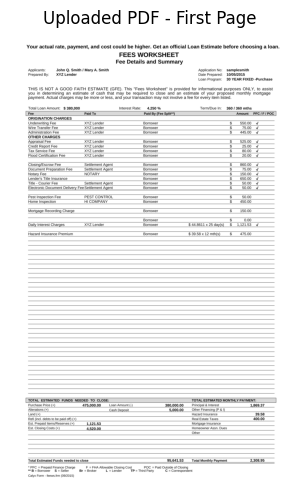

In [36]:
# Upload PDF
print("📁 Upload your PDF:")
uploaded = files.upload()
pdf_path = f"/content/{list(uploaded.keys())[0]}"

# Convert to image
images = convert_from_path(pdf_path, dpi=300)
image = images[0]  # Use first page
# Save image as file (EasyOCR works better with file paths)
image_path = '/content/page.png'
image.save(image_path)

# Show uploaded image
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.title('Uploaded PDF - First Page')
plt.axis('off')
plt.show()

In [37]:
# EasyOCR Processing
print("🔍 Running EasyOCR...")

# Create reader (English)
reader = easyocr.Reader(['en'])

# Extract text
result = reader.readtext(image_path)

🔍 Running EasyOCR...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [42]:
# Draw bounding boxes and extract text
img_copy = image.copy()
draw = ImageDraw.Draw(img_copy)
extracted_text = []


for (bbox, text, confidence) in result:
    if confidence > 0.5:  # Filter by confidence
        # Draw bounding box
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        draw.rectangle([top_left, bottom_right], outline='red', width=2)

        # Add confidence score
        draw.text((top_left[0], top_left[1]-20), f"{confidence:.2f}", fill='red')

        extracted_text.append(text)

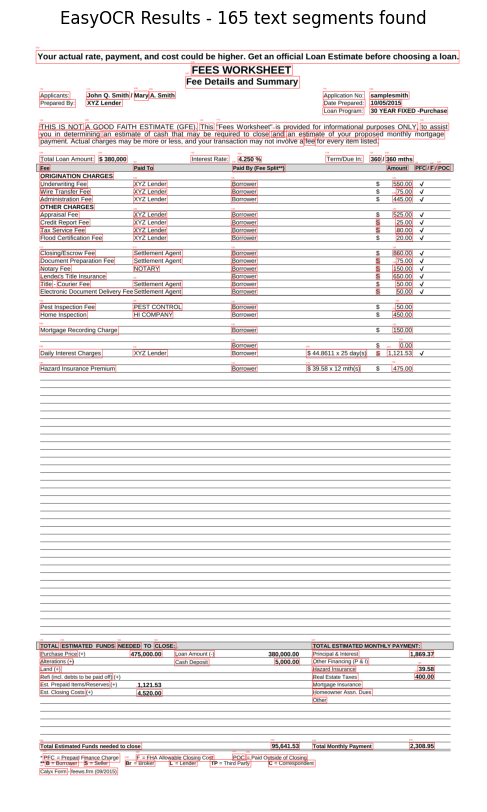

In [39]:

# Display results
plt.figure(figsize=(15, 10))
plt.imshow(img_copy)
plt.title(f'EasyOCR Results - {len(extracted_text)} text segments found')
plt.axis('off')
plt.show()

In [40]:
# Print extracted text
print(f"\n📝 Extracted Text ({len(extracted_text)} segments):")
print("-" * 50)
for i, text in enumerate(extracted_text, 1):
    print(f"{i:2d}. {text}")

print(f"\n✅ EasyOCR completed successfully!")


📝 Extracted Text (165 segments):
--------------------------------------------------
 1. Your actual rate, payment; and cost could be higher. Get an official Loan Estimate before choosing a Ioan.
 2. FEES WORKSHEET
 3. Fee Details and Summary
 4. Applicants:
 5. John Q. Smith
 6. A. Smith
 7. Application No:
 8. samplesmith
 9. Prepared By:
10. XYZ Lender
11. Date Prepared:
12. 10/05/2015
13. Loan Program:
14. 30 YEAR FIXED -Purchase
15. THIS IS NOT
16. A GOOD FAITH ESTIMATE (GFE):
17. This
18. "Fees Worksheet" is provided for informational purposes ONLY,
19. to assist
20. you in determining
21. an estimate of cash that may be required to close
22. and
23. an estimate of your proposed monthly mortgage
24. payment: Actual charges may be more or less, and your transaction may not involve a
25. for every item listed:
26. Total Loan Amount:
27. $ 380,000
28. Interest Rate:
29. 4.250 %
30. TermlDue In:
31. 360
32. 360 mths
33. Fee
34. Paid To
35. Paid By (Fee_Splittt)
36. Amount
37. PFC
38.